# IBM Machine Learning
## Course 5: Deep Learning
## Topic: English Handwritten Characters

### 1. Introduction

We will work on the handwritten English dataset, which consists of 3410 images. The characters include 0-9, A-Z and a-z, 62 classes in total and each image is map to only one label.
The objective is to classify the images to the correct label.
The dataset can be found in this link: https://www.kaggle.com/dhruvildave/english-handwritten-characters-dataset?select=Img

### 2. Exploratory Data Analysis

#### 2.1 import the data

In [141]:
## import the library
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import warnings

warnings.filterwarnings('ignore')

In [142]:
## load the data label
df=pd.read_csv("data/english.csv")

In [143]:
## the first 5 rows in the label file
df.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [144]:
## As describe in introduction, there 3410 records.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3410 non-null   object
 1   label   3410 non-null   object
dtypes: object(2)
memory usage: 53.4+ KB


In [145]:
## Process the image column
df['image']=df['image'].str.split('/').str[1]
df['image']

0       img001-001.png
1       img001-002.png
2       img001-003.png
3       img001-004.png
4       img001-005.png
             ...      
3405    img062-051.png
3406    img062-052.png
3407    img062-053.png
3408    img062-054.png
3409    img062-055.png
Name: image, Length: 3410, dtype: object

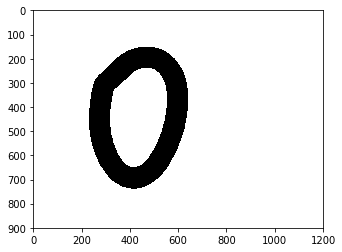

In [146]:
## check the image and corresponding label
img=mpimg.imread('data/'+df['image'][0])
plt.imshow(img)

In [147]:
df['label'][0]

'0'

#### 2.2 convert each image to 2D array

From the image we can see that each image have 900 pixels in height and 1200 pixels in width. We have 3409 iamges. If we use the original dimension, it will need a few GB memory. we will compress and convert each image to an array of size(30, 40)

In [148]:
from sklearn.preprocessing import LabelEncoder

# before resize
image=Image.open('data/'+df['image'][0]).convert('L')

In [149]:
print(image.format)
print(image.size)
print(image.mode)

None
(1200, 900)
L


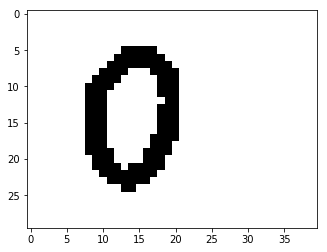

In [150]:
# after resize
new_image=image.resize((40,30))
plt.imshow(new_image)

In [151]:
# the size 
np.asarray(new_image).shape

(30, 40)

In [152]:
# create the dataset for the pixel value of each image
L=[]
for image in df['image']:
    rawData=np.asarray(Image.open('data/'+image).convert('L').resize((40,30)))
    L.append(rawData)

In [153]:
# convert to numpy array
len(L)
X=np.array(L)
X.shape

(3410, 30, 40)

In [154]:
# create the data for label 
y=df['label']

In [155]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values 
y=labelencoder.fit_transform(y)

#### 2.3 Data preprocess

In [156]:
# Let's make everything float and scale
X=X.astype('float32')
X/=255

#### 2.4 Data splitted into training and test

In [157]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [158]:
x_train.shape

(2557, 30, 40)

### 3. Build Model

#### 3.1 Get a baseline performance using Random Forest

In [159]:
## flatten our data
x_train_flat=x_train.reshape(len(x_train), -1)
x_test_flat=x_test.reshape(len(x_test), -1)

In [160]:
## the size of training 
print('x_train_flat shape:', x_train_flat.shape)

x_train_flat shape: (2557, 1200)


In [161]:
## the size of testing
print('x_test_flat shape:', x_test_flat.shape)

x_test_flat shape: (853, 1200)


In [162]:
import datetime
#used to help some of the timing functions
now = datetime.datetime.now

In [163]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Train the RF Model
t = now()
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(x_train_flat, y_train)
print('Training time: %s' % (now() - t))

Training time: 0:00:02.186125


In [164]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(x_test_flat)
y_pred_prob_rf = rf_model.predict_proba(x_test_flat)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))

accuracy is 0.449


In [165]:
confusion_matrix(y_test,y_pred_class_rf)

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  4,  0,  1],
       [ 0,  0,  0, ...,  1,  5,  0],
       [ 0,  0,  1, ...,  1,  0,  5]], dtype=int64)

As we can see above, the training time is long and the accuracy is quite low(less than 50%)

#### 3.2 Build a full connected neural network

In [166]:
num_classes = len(set(y))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [167]:
model_1=Sequential()
model_1.add(Dense(100,input_shape=(1200,), activation='sigmoid'))
model_1.add(Dense(62,activation='softmax'))

In [168]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_11 (Dense)             (None, 62)                6262      
Total params: 126,362
Trainable params: 126,362
Non-trainable params: 0
_________________________________________________________________


In [169]:
t = now()

# Compile the model with Optimizer, Loss Function and Metrics
opt_1 = keras.optimizers.RMSprop(lr=0.0005)

model_1.compile(optimizer=opt_1, loss="categorical_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(x_train_flat, y_train, validation_data=(x_test_flat, y_test), epochs=200)

print('Training time: %s' % (now() - t))

Epoch 1/200
80/80 [==============================] - 0s 3ms/step - loss: 4.1787 - accuracy: 0.0160 - val_loss: 4.1254 - val_accuracy: 0.0211
Epoch 2/200
80/80 [==============================] - 0s 2ms/step - loss: 4.1243 - accuracy: 0.0235 - val_loss: 4.1042 - val_accuracy: 0.0457
Epoch 3/200
80/80 [==============================] - 0s 1ms/step - loss: 4.0929 - accuracy: 0.0305 - val_loss: 4.0581 - val_accuracy: 0.0352
Epoch 4/200
80/80 [==============================] - 0s 1ms/step - loss: 4.0302 - accuracy: 0.0372 - val_loss: 4.0225 - val_accuracy: 0.0399
Epoch 5/200
80/80 [==============================] - 0s 1ms/step - loss: 3.9689 - accuracy: 0.0571 - val_loss: 3.9600 - val_accuracy: 0.0715
Epoch 6/200
80/80 [==============================] - 0s 1ms/step - loss: 3.9033 - accuracy: 0.0755 - val_loss: 3.9012 - val_accuracy: 0.0680
Epoch 7/200
80/80 [==============================] - 0s 1ms/step - loss: 3.8296 - accuracy: 0.1060 - val_loss: 3.8459 - val_accuracy: 0.0797
Epoch 8/200
8

Epoch 59/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0808 - accuracy: 0.4963 - val_loss: 2.6564 - val_accuracy: 0.3669
Epoch 60/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0723 - accuracy: 0.5057 - val_loss: 2.6330 - val_accuracy: 0.3646
Epoch 61/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0624 - accuracy: 0.5053 - val_loss: 2.6518 - val_accuracy: 0.3623
Epoch 62/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0498 - accuracy: 0.5158 - val_loss: 2.6741 - val_accuracy: 0.3540
Epoch 63/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0339 - accuracy: 0.5029 - val_loss: 2.6312 - val_accuracy: 0.3681
Epoch 64/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0186 - accuracy: 0.5123 - val_loss: 2.6320 - val_accuracy: 0.3587
Epoch 65/200
80/80 [==============================] - 0s 1ms/step - loss: 2.0082 - accuracy: 0.5151 - val_loss: 2.6527 - val_accuracy: 0.3599
Epoch 

80/80 [==============================] - 0s 1ms/step - loss: 1.4801 - accuracy: 0.6390 - val_loss: 2.5525 - val_accuracy: 0.3705
Epoch 117/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4696 - accuracy: 0.6414 - val_loss: 2.5132 - val_accuracy: 0.3892
Epoch 118/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4585 - accuracy: 0.6437 - val_loss: 2.5079 - val_accuracy: 0.3740
Epoch 119/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4584 - accuracy: 0.6476 - val_loss: 2.5949 - val_accuracy: 0.3693
Epoch 120/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4416 - accuracy: 0.6469 - val_loss: 2.5203 - val_accuracy: 0.3927
Epoch 121/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4348 - accuracy: 0.6461 - val_loss: 2.5352 - val_accuracy: 0.3834
Epoch 122/200
80/80 [==============================] - 0s 1ms/step - loss: 1.4263 - accuracy: 0.6562 - val_loss: 2.5212 - val_accuracy: 0.3857
Epoch 123/200

80/80 [==============================] - 0s 1ms/step - loss: 1.0443 - accuracy: 0.7575 - val_loss: 2.5473 - val_accuracy: 0.3810
Epoch 174/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0376 - accuracy: 0.7689 - val_loss: 2.5653 - val_accuracy: 0.3845
Epoch 175/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0343 - accuracy: 0.7654 - val_loss: 2.5836 - val_accuracy: 0.3939
Epoch 176/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0191 - accuracy: 0.7673 - val_loss: 2.5516 - val_accuracy: 0.3857
Epoch 177/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0131 - accuracy: 0.7669 - val_loss: 2.5816 - val_accuracy: 0.3927
Epoch 178/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0061 - accuracy: 0.7689 - val_loss: 2.5957 - val_accuracy: 0.3810
Epoch 179/200
80/80 [==============================] - 0s 1ms/step - loss: 1.0087 - accuracy: 0.7646 - val_loss: 2.6407 - val_accuracy: 0.3916
Epoch 180/200

In [170]:
score = model_1.evaluate(x_test_flat, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.60488224029541
Test accuracy: 0.3821805417537689


The full connection neural network perform no better than random forest. The accuray is similar to random forest. We can increase the hidden layers and number of epochs, however the time will increase too.

#### 3.3 Convolutional Neural Network

In [171]:
# set some parameters
img_rows, img_cols=x_train.shape[1:]
input_shape = (img_rows, img_cols, 1)

filters = 32
pool_size = 2
kernel_size = 3

In [172]:
input_shape

(30, 40, 1)

In [173]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 4), padding='same',
                 input_shape=input_shape))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 4), padding='same',
                 input_shape=input_shape))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 4)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [174]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 40, 32)        416       
_________________________________________________________________
activation_17 (Activation)   (None, 30, 40, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 40, 32)        12320     
_________________________________________________________________
activation_18 (Activation)   (None, 30, 40, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 64)      

In [175]:
batch_size = 32

# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(lr=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [176]:
x_train=x_train.reshape((x_train.shape[0],)+input_shape)
x_test=x_test.reshape((x_test.shape[0],)+input_shape)

In [179]:
t = now()
model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True)
print('Training time: %s' % (now() - t))

Epoch 1/30
80/80 [==============================] - 6s 70ms/step - loss: 1.2305 - accuracy: 0.6277 - val_loss: 1.1017 - val_accuracy: 0.6917
Epoch 2/30
80/80 [==============================] - 5s 67ms/step - loss: 1.1552 - accuracy: 0.6461 - val_loss: 1.0788 - val_accuracy: 0.6917
Epoch 3/30
80/80 [==============================] - 5s 67ms/step - loss: 1.0053 - accuracy: 0.6899 - val_loss: 1.0149 - val_accuracy: 0.7069
Epoch 4/30
80/80 [==============================] - 5s 68ms/step - loss: 0.9632 - accuracy: 0.7004 - val_loss: 0.9579 - val_accuracy: 0.7128
Epoch 5/30
80/80 [==============================] - 6s 72ms/step - loss: 0.8756 - accuracy: 0.7223 - val_loss: 0.9342 - val_accuracy: 0.7280
Epoch 6/30
80/80 [==============================] - 5s 69ms/step - loss: 0.8299 - accuracy: 0.7368 - val_loss: 0.9239 - val_accuracy: 0.7245
Epoch 7/30
80/80 [==============================] - 5s 68ms/step - loss: 0.7681 - accuracy: 0.7450 - val_loss: 0.8713 - val_accuracy: 0.7351
Epoch 8/30
80

In [180]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.8297411799430847
Test accuracy: 0.7936694025993347


### 4. Conclusion

This task involves in recognizing hand wirtten english characters. There are more than 60 categories. We know that it is more difficult compared to MNIST digit data classification. For example, z may look like 2 or B may look like 8 and so on. 
From the analysis above, we found that convolution neural network can achieve very high accuracy for image classification. Each pixel can be treated as one feature. The relative location and value of each pixel is very important for image. The final accuracy in test set is close to 80% while the training accuracy is 90%. It indicates there may be some overfitting. This model is still very simple, using deep neural network to build more layers and using dropout regularization may help to achieve higher accuracy.   

In this course, we learn different deep learning architecture. They are suitable for different task. 